Importing Libraries

transfoermer - huggingface library for loading the BERT model and tokenizer

datasets for making tf.data pipelines

spacy for lemmitization and nltk for stopword removal


In [11]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset , Dataset
import pandas as pd
import spacy
from nltk.corpus import stopwords
import re
import nltk


Initialising the model and tokenizer instance for bert base model

In [12]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

preprocessing funtion for the Text in the dataset

In [13]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) #lower casing and remove special characters using regex


    doc = nlp(text)

    lemmatized = [token.lemma_ for token in doc if token.is_alpha] #lemmitization

    filtered = [word for word in lemmatized if word not in stop_words and len(word) > 2] #stopword removal


    return " ".join(filtered)

[nltk_data] Downloading package stopwords to /home/sm4th/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preparing the pandas dataframe

In [14]:
df = pd.read_csv("train.csv")
df["Text"] = df["Text"].apply(preprocess_text)


df['encoded_categories'] = df['Category'].astype('category').cat.codes #converting the categories into one encodings for model training
print(df.head(10))

data_text = df['Text'].to_list() #converting to list for tokenisation and splitting
data_labels = df['encoded_categories'].to_list()

     Category                                               Text  \
0  Accountant  education omba executive leadership university...   
1  Accountant  howard gerrard accountant deyjobcom birmingham...   
2  Accountant  kevin frank senior accountant inforesumekraftc...   
3  Accountant  place birth nationality olivia ogilvy accounta...   
4  Accountant  stephen greet cpa senior accountant year exper...   
5  Accountant  marie anderson sometown masomedomaincom linked...   
6  Accountant  carole chun kismis singapore supportresumeedge...   
7  Accountant  anna gunther senior accountant annanovoresumec...   
8  Accountant  first last cost accountant new york city first...   
9  Accountant  robert smith associate accountant phone email ...   

   encoded_categories  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9          

Splitting into Train , Test and Validation sets

first split - 90% train and 10%validation
second split - 10% of train --> test set

In [15]:
from sklearn.model_selection import train_test_split

train_text , val_text , train_labels , val_labels = train_test_split(data_text, data_labels, test_size  = 0.1 , random_state = 0)

train_text , test_text , train_labels , test_labels = train_test_split(train_text, train_labels , test_size =0.1, random_state = 0)

Tokenize each set , this outputs tensorflow tensors .

Tokenizer adds input_ids, attention_maks


padding and truncation are True as we want padding for token less than required size and truncation for token more than required size

In [16]:
train_encodings = tokenizer(train_text, padding=True, truncation=True, return_tensors='tf')
validation_encodings = tokenizer(val_text, padding=True, truncation =True, return_tensors = 'tf')
test_encodings = tokenizer(test_text, padding=True, truncation=True, return_tensors='tf')

Convert labels to tensors

needed for tf training format

In [17]:
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int64)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int64)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int64)

Create tf Datasets , input pipeline

set batch size = 8 due to computational limitations

shuffle is for randomising on each epoch

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'token_type_ids': train_encodings['token_type_ids'],
    },
    train_labels
)).shuffle(1000).batch(4)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'token_type_ids': test_encodings['token_type_ids'],
    },
    test_labels
)).batch(4)

validation_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': validation_encodings['input_ids'],
        'attention_mask': validation_encodings['attention_mask'],
        'token_type_ids': validation_encodings['token_type_ids'],
    },
    val_labels
)).batch(4)

Define a BERT Classifier with a FC layer at end using softmax activation

In [19]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

classifier = BERTForClassification(model, num_classes=43)

Compiling and Training

In [20]:
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = classifier.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=3
)

Epoch 1/3


I0000 00:00:1748439787.840150   28438 service.cc:152] XLA service 0x779550ce0b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748439787.840170   28438 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-28 19:13:07.851274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748439787.876818   28438 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748439788.004716   28438 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2712/2712 [==============================] - 829s 295ms/step - loss: 1.3183 - accuracy: 0.6964 - val_loss: 0.5886 - val_accuracy: 0.8641
Epoch 2/3
2712/2712 [==============================] - 792s 292ms/step - loss: 0.4300 - accuracy: 0.8970 - val_loss: 0.5329 - val_accuracy: 0.8738
Epoch 3/3
2712/2712 [==============================] - 792s 292ms/step - loss: 0.2874 - accuracy: 0.9285 - val_loss: 0.4607 - val_accuracy: 0.8902


Plot training/validation accuracy and loss curves

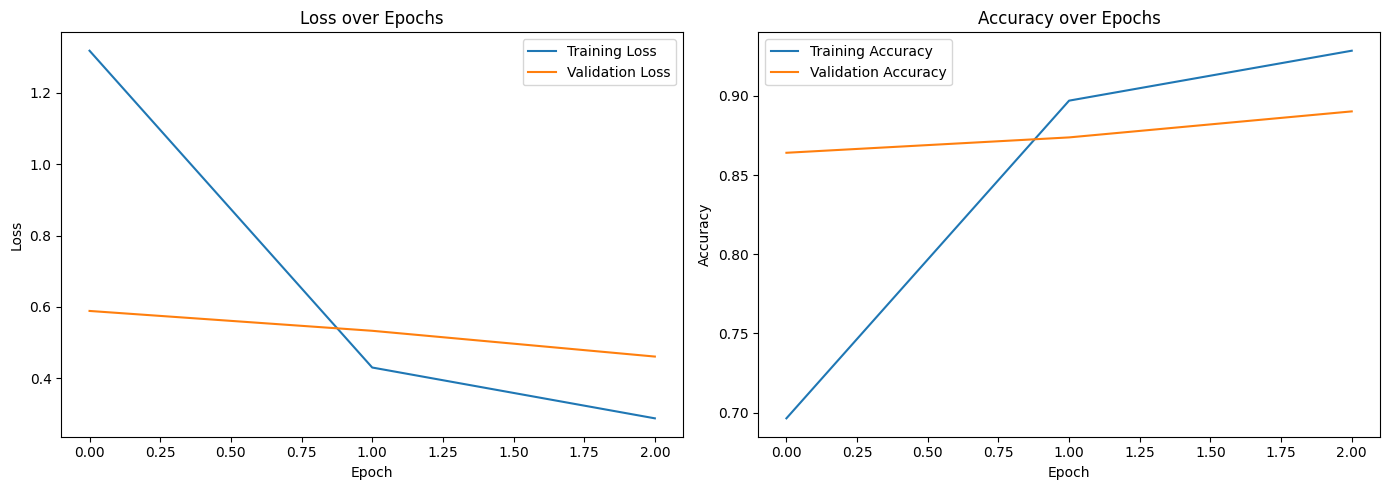

In [21]:
import matplotlib.pyplot as plt
import numpy

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Final Evaluation on test Dataset

In [22]:
classifier.evaluate(test_dataset)


302/302 [==============================] - 31s 102ms/step - loss: 0.4551 - accuracy: 0.8896


[0.4550763666629791, 0.8896265625953674]

Classification Report

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1-score = harmonic mean of precision and recall

Support = number of true examples for each class

In [23]:
from sklearn.metrics import classification_report

y_pred_list = [] #predicted labels
y_true_list = [] #true labels

for batch_inputs, batch_labels in test_dataset: #in batch for memory efficiency
    logits = classifier(batch_inputs, training=False) #gets prediction for each abtch
    batch_predictions = tf.argmax(logits, axis=1).numpy()
    y_pred_list.extend(batch_predictions)
    y_true_list.extend(batch_labels.numpy())

y_pred = numpy.array(y_pred_list)
y_true = numpy.array(y_true_list)


print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9394    0.9688        33
           1     0.9200    0.8846    0.9020        26
           2     1.0000    0.8182    0.9000        22
           3     0.9091    0.7143    0.8000        28
           4     0.9091    0.7692    0.8333        26
           5     0.7500    1.0000    0.8571        24
           6     0.8929    0.8333    0.8621        30
           7     1.0000    0.9355    0.9667        31
           8     0.7500    0.7826    0.7660        23
           9     1.0000    0.9688    0.9841        32
          10     0.0000    0.0000    0.0000         1
          11     0.8621    1.0000    0.9259        25
          12     0.8684    0.9429    0.9041        35
          13     0.9667    0.9667    0.9667        30
          14     0.8462    0.7333    0.7857        30
          15     0.8462    0.8800    0.8627        25
          16     1.0000    0.6667    0.8000        18
          17     0.9643    

2025-05-28 19:54:08.254341: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/sm4th/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sm4th/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sm4th/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U